In [1]:
%reload_ext autoreload
%autoreload 2

In [61]:
import numpy as np
import pandas as pd
import mat73 as mt
import scipy.io as sio
import matplotlib.pyplot as plt

from pathlib import Path

from fppnpx2.NPXSession import read_session, load_waveforms, ChannelSignal

## New stuff

In [ ]:
# imecpath = Path('/home/mateoumaguing/Documents/MiscData/TibsCFD/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0')

In [85]:
tester = read_session([204,209], bandtype='AP')

2025-07-30 00:07:40.822 python[1175:12458] +[CATransaction synchronize] called within transaction
2025-07-30 00:07:40.918 python[1175:12458] +[CATransaction synchronize] called within transaction
2025-07-30 00:07:41.091 python[1175:12458] +[CATransaction synchronize] called within transaction
2025-07-30 00:07:43.018 python[1175:12458] +[CATransaction synchronize] called within transaction


Creating session from /Users/mateouma/Desktop/TIBERIUS_CHKDLAY_DLPFC_NPIX45_063023_g0
Reading metadata...
Reading recorded signal...
383 usable channels. Use `channel_map` to get usable channels.
Reading cluster information from kilosort...
Session loading complete.


In [ ]:
# waveforms = sio.loadmat("/home/mateoumaguing/Documents/MiscData/TibsCFD/CHKDLAY_063023_waveforms.mat")

In [ ]:
waveform_dataset, waveform_means = load_waveforms("/Users/mateouma/Downloads/monkey datasets/20230630_DLPFCwaveforms.mat", tester)

Loading waveforms...
138 clusters with good waveforms.


In [98]:
waveform_dataset[296]

{'time_filter': array([-0.287,  0.134,  0.047, ...,  0.   ,  0.   ,  0.   ]),
 'freq_filter': array([-6.70666667e-05-1.48029737e-18j, -6.70672531e-05+4.79578616e-08j,
        -6.70690123e-05+9.59348931e-08j, ...,
        -6.70719439e-05-1.43950261e-07j, -6.70690123e-05-9.59348931e-08j,
        -6.70672531e-05-4.79578616e-08j]),
 'filter_psd': array([4.49793778e-09, 4.49801874e-09, 4.49826162e-09, ...,
        4.49866638e-09, 4.49826162e-09, 4.49801874e-09]),
 'filter_freq_axis': array([-15000.        , -14998.99996667, -14997.99993333, ...,
         14997.99993333,  14998.99996667,  15000.        ]),
 'mean_waveform': array([  7.423,   7.844,   7.757,   7.721,   7.664,   7.427,   7.125,
          7.3  ,   7.32 ,   7.651,   7.228,   7.249,   7.082,   7.193,
          7.043,   6.608,   3.587, -10.475, -41.799, -68.549, -77.884,
        -73.895, -64.421, -56.472, -53.203, -42.866, -22.944,  -1.421,
         19.323,  36.638,  48.978,  56.42 ,  60.532,  62.662,  63.162,
         61.57 ,  58

In [92]:
gabagoo = ChannelSignal(163, tester, waveform_dataset)

Multitaper frequency resolution: 1.2
Multitaper number of tapers: 5


In [97]:
gabagoo.dominant_units

array([296])

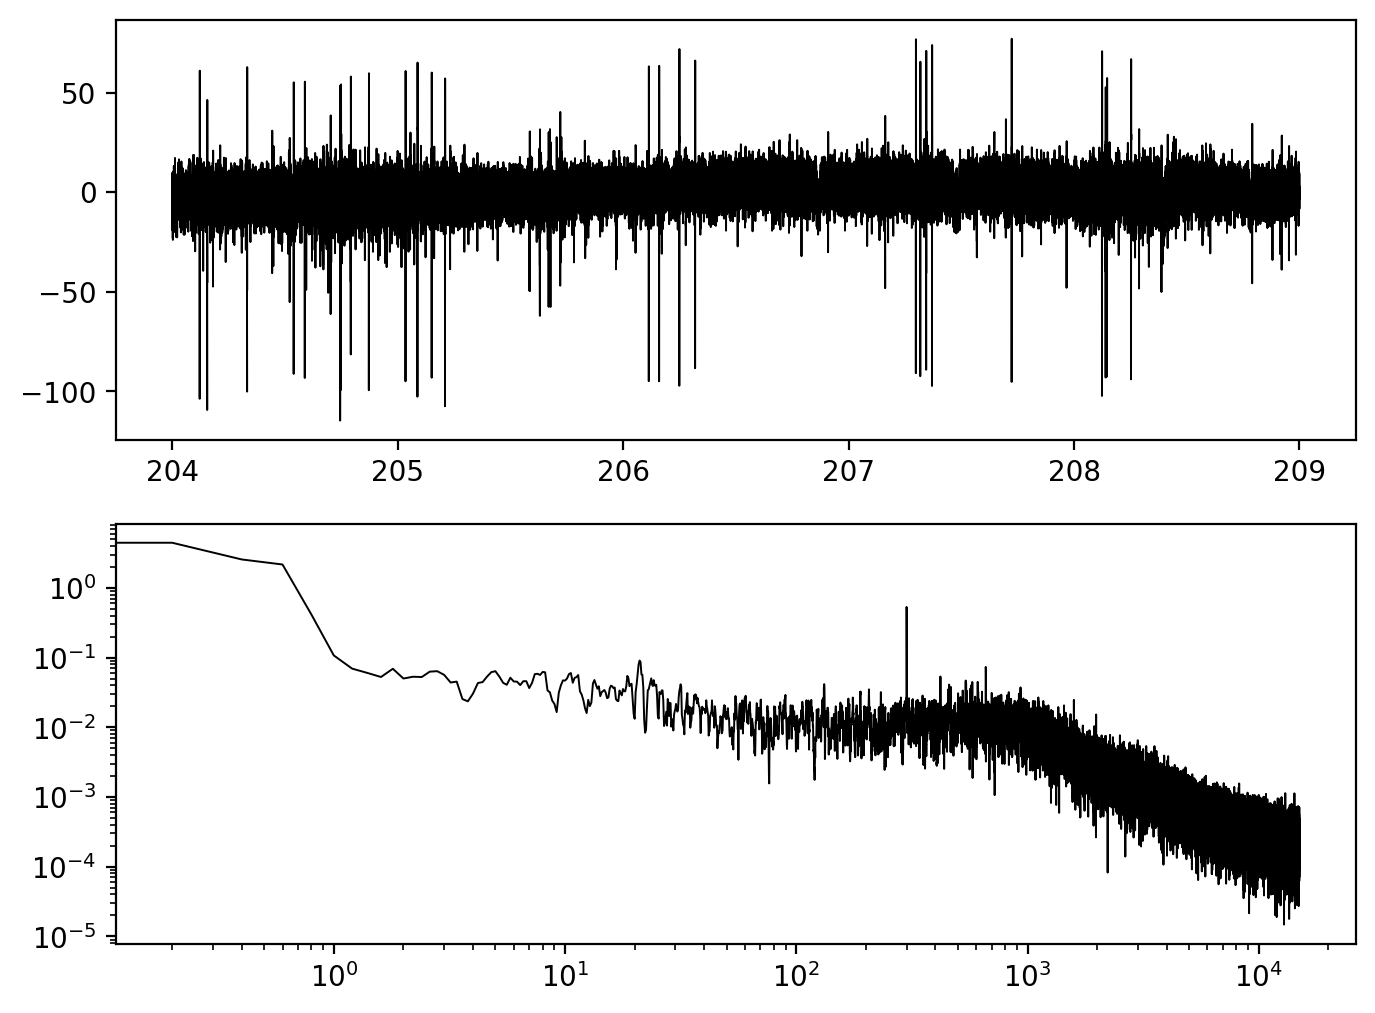

In [95]:
fig, ax = plt.subplots(2, figsize=(8,6),dpi=200)
gabagoo.plot_time_series(ax=ax[0])
gabagoo.plot_spectrum(log=True, ax=ax[1])